# Medical Cost Dataset
This Jupyter notebook contains the code used during OUAIxHacklahoma workshop for Fall 2021 (December 1st, 2021). Credits given to _miri choi_ from Kaggle for collecting and organizing the provided ["Medical Cost Dataset"](https://www.kaggle.com/mirichoi0218/insurance).

Objectives
--------------

This jupyter notebook implements a solution to best categorize charges incurred to a person for insurance. This task is exclusively of regression, and the insurance cost is in dollars.

In [1]:
import numpy as np
import pandas as pd

Data Obtention
============

The Medical Cost dataset is provided in the datasets folder. We use Pandas's `read_csv` function. More formats are supported; read more in pandas [documentation](https://pandas.pydata.org/docs/reference/io.html).

In [2]:
insurance = pd.read_csv('datasets/insurance.csv')

Data Discovery
============

__It is important for us to gain an understanding of our data before performing any kind of learning or analysis.__ It is important to note that by "Discovery" we mean understanding what attributes and data types the dataset includes. This also includes identifying usefull and useless data attributes (such as dates or indexes). At this stage we want to focus in geting a grasp on what needs to be done next to achieve our goals.

### Look at the dataset's attributes.

In [3]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

### Look at the 7 first and last entries.

In [4]:
insurance.head(7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960


In [5]:
insurance.tail(7)

,age,sex,bmi,children,smoker,region,charges
1331,23,female,33.40,0,no,southwest,10795.93733
1332,52,female,44.70,3,no,southwest,11411.68500
1333,50,male,30.97,3,no,northwest,10600.54830
1334,18,female,31.92,0,no,northeast,2205.98080
1335,18,female,36.85,0,no,southeast,1629.83350
1336,21,female,25.80,0,no,southwest,2007.94500
1337,61,female,29.07,0,yes,northwest,29141.36030


### See what kind of data the dataset contains.
Note that `sex`, `smoker`, and `region` attributes are shown as `object` Dtype. When data is first imported into sklearn, strings are represented as object types. Oftentimes, this data is categorical, and because we have imported a CSV data file we can rest assured that the columns will be categorical. We can further prove this by taking a look at the values that exist within the suspected categorical attributes.

In [6]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
insurance['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

## Dataset Statistics

The `describe()` function provided by Pandas allows us to get a glimpse into the statistical relationships going on in the dataset. This information can be useful to gain a better understanding of the dataset itself.

In [8]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Note that only __4__ attributes are displayed. This is due to the fact that the describe function only looks at numerical data. Other types of data are ignored.

#### Plotting the dataset

We can further gain knowledge by ploting the dataset. Pay close attention to the distribution! The `hist()` function allows us to plot a historgram. These are very useful when dealing with data that may have different statistical distributions. The `bins` parameter allows us to choose how many "rectangles" to include in a single histogram. The `figsize` allows us to determine the size of the histogram (y, x).

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

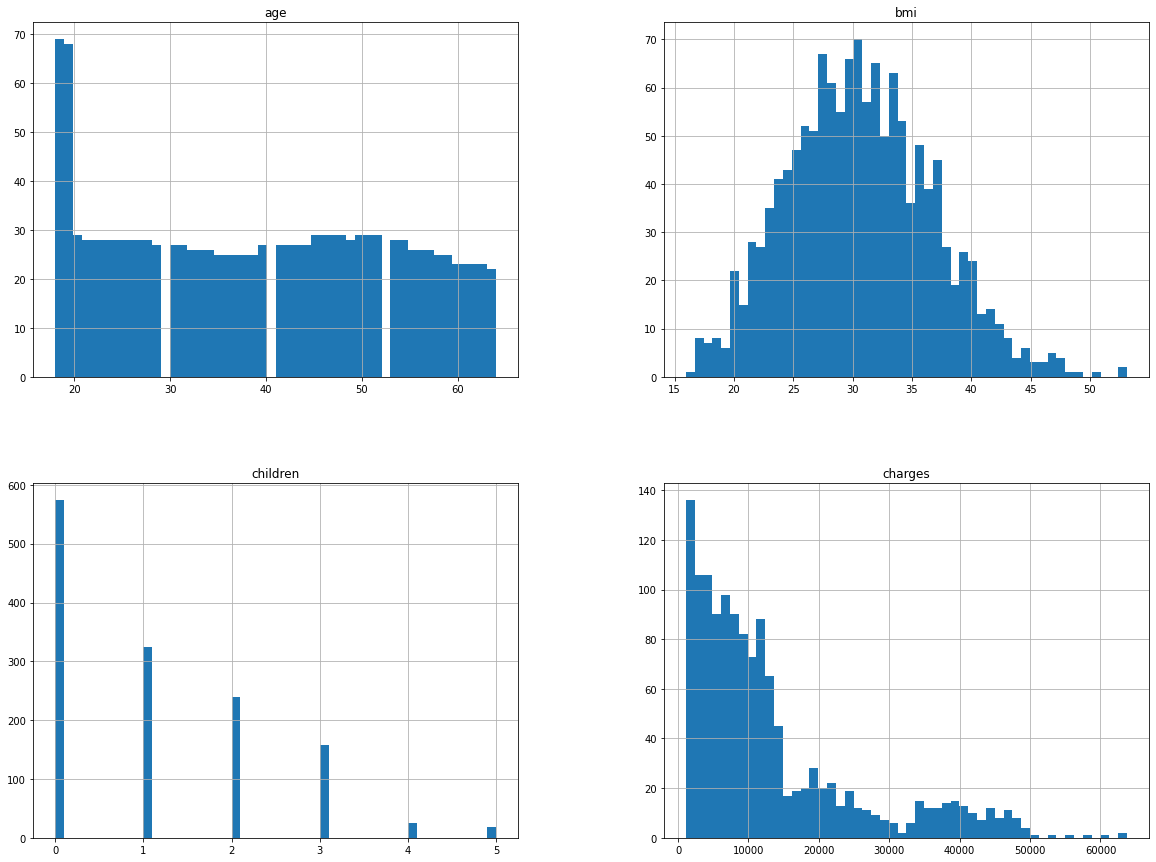

In [9]:
insurance.hist(bins=50, figsize=(20, 15))

# Dataset Preparation

Once we have gained a better understanding of the kind of data that we are dealing with, it is important to avoid making assumptions on the dataset. This is because certain attributes may not influence the final prediction as we may think. This is crucial when seeking the best machine learning model.

When working with machine learning, it is very important for us to prepare the dataset for training. This is accomplished by first separating the data into two parts: _Training_ and _Testing_. Doing this will allow us to maintain a neutral position on the dataset and avoid outside bias from interfering with the learning process. Additionally, we will be using the testing dataset after we perform learning in order for us to test how well our model does with unseen data. At the end of the day, we care about a model that can do well with unseen data rather than just the data that it has learned already.

`StratifiedShuffleSplit` is a commonly-used splitting technique to separate the training from the testing sub-datasets. It uses a categorical attribute to keep the best representation among the datasets. In data science, the __80/20__ splitting rule is the most used splitting distribution. We keep 80% for our training data and 20% for our testing data.

### How do we choose which attribute to split on?

Expert advise is best when deciding what attribute to use. In general, it is a good idea to split your dataset using as basis an attribute that may be very important for machine learning; thus, it is benefitial to maintain the best representation of the data possible.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

attrib = 'age'
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_i, test_i in split.split(insurance, insurance[attrib]):
    strat_train_set = insurance.loc[train_i]
    strat_test_set = insurance.loc[test_i]

In [11]:
strat_train_set.head()

,age,sex,bmi,children,smoker,region,charges
1218,46,female,34.600,1,yes,southwest,41661.60200
669,40,female,29.810,1,no,southeast,6500.23590
618,19,female,33.110,0,yes,southeast,34439.85590
58,53,female,22.880,1,yes,southeast,23244.79020
902,26,male,27.265,3,no,northeast,4661.28635


In [12]:
strat_test_set.head()

,age,sex,bmi,children,smoker,region,charges
949,25,male,29.700,3,yes,southwest,19933.45800
606,27,female,25.175,0,no,northeast,3558.62025
830,63,male,33.100,0,no,southwest,13393.75600
1014,38,female,27.600,0,no,southwest,5383.53600
124,47,female,33.915,3,no,northwest,10115.00885


We can apreciate the dataset distribution

<AxesSubplot:>

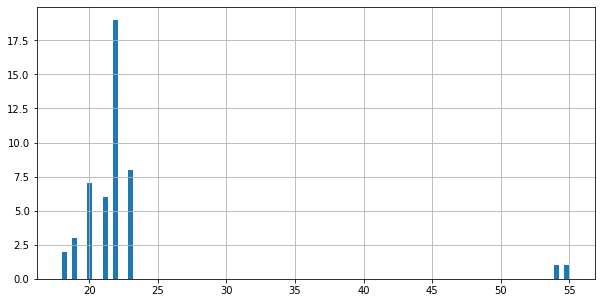

In [13]:
# Train dataset
strat_train_set[attrib].value_counts().hist(bins=100, figsize=(10, 5))

<AxesSubplot:>

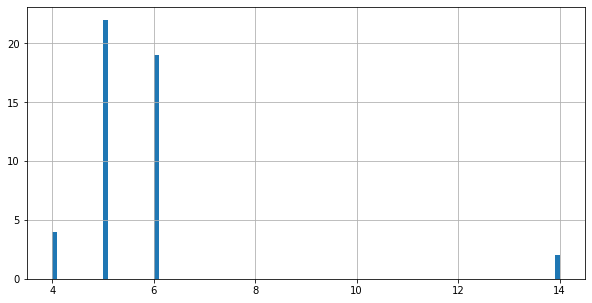

In [14]:
# Test dataset
strat_test_set[attrib].value_counts().hist(bins=100, figsize=(10, 5))

<AxesSubplot:>

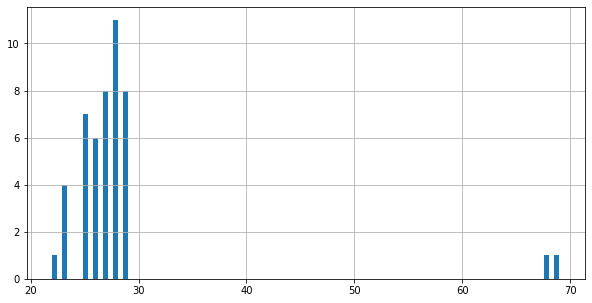

In [15]:
# The distribution is kept if the graphs of the other datasets resemble this one.
insurance[attrib].value_counts().hist(bins=100, figsize=(10, 5))

From now on, __only use the training dataset__ to perform any further data analysis.

## Correlations

Given that in data science we are attempting to find correlations within the data that could give the machine learning model better insights, it is a good idea to check what attributes may be the most useful for this. Note that this will only work with numerical data, thus, we may not be able to use simple Pearson correlation on attributes that are categorical or `object` type.

In [16]:
# Create a correlation matrix
corr_matrix = strat_train_set.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.274163
bmi         0.209491
children    0.069946
Name: charges, dtype: float64

It seems to be that age is the best predictor of insurance cost. Note that this correlation value is very low. Since a significant number of attributes are `object` type it is worth the attempt to try and convert those attributes to a numerical encoding to check if there are better correlations. To do this, we can use sklearn's OrdinalEncoder to convert categorical strings into numerical form.

In [17]:
from sklearn.preprocessing import OrdinalEncoder

cat_cols = ['sex', 'smoker', 'region']
oe = OrdinalEncoder()
strat_train_set[cat_cols] = oe.fit_transform(strat_train_set[cat_cols])

strat_train_set.describe()

,age,sex,bmi,children,smoker,region,charges
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.280374,0.515888,30.818196,1.081308,0.206542,1.516822,13375.571065
std,14.052351,0.499981,6.088495,1.181367,0.405013,1.099875,12245.142274
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.410000,0.000000,0.000000,1.000000,4746.521225
50%,39.000000,1.000000,30.500000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.800000,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


In [18]:
# Create a correlation matrix and check correlations again
corr_matrix = strat_train_set.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.800094
age         0.274163
bmi         0.209491
children    0.069946
sex         0.058434
region     -0.022080
Name: charges, dtype: float64

Note how being a smoker gives a positive correlation. This correlation is also much better than any other attribute.

### Scatter Matrix

We can further visualize any correlations among the data attributes by using a correlation matrix. This can help us better observe the above correlations.

In [19]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='sex', ylabel='age'>,
        <AxesSubplot:xlabel='bmi', ylabel='age'>,
        <AxesSubplot:xlabel='children', ylabel='age'>,
        <AxesSubplot:xlabel='smoker', ylabel='age'>,
        <AxesSubplot:xlabel='region', ylabel='age'>,
        <AxesSubplot:xlabel='charges', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='sex'>,
        <AxesSubplot:xlabel='sex', ylabel='sex'>,
        <AxesSubplot:xlabel='bmi', ylabel='sex'>,
        <AxesSubplot:xlabel='children', ylabel='sex'>,
        <AxesSubplot:xlabel='smoker', ylabel='sex'>,
        <AxesSubplot:xlabel='region', ylabel='sex'>,
        <AxesSubplot:xlabel='charges', ylabel='sex'>],
       [<AxesSubplot:xlabel='age', ylabel='bmi'>,
        <AxesSubplot:xlabel='sex', ylabel='bmi'>,
        <AxesSubplot:xlabel='bmi', ylabel='bmi'>,
        <AxesSubplot:xlabel='children', ylabel='bmi'>,
        <AxesSubplot:xlabel='smoker', ylabel='bmi'>,
        <A

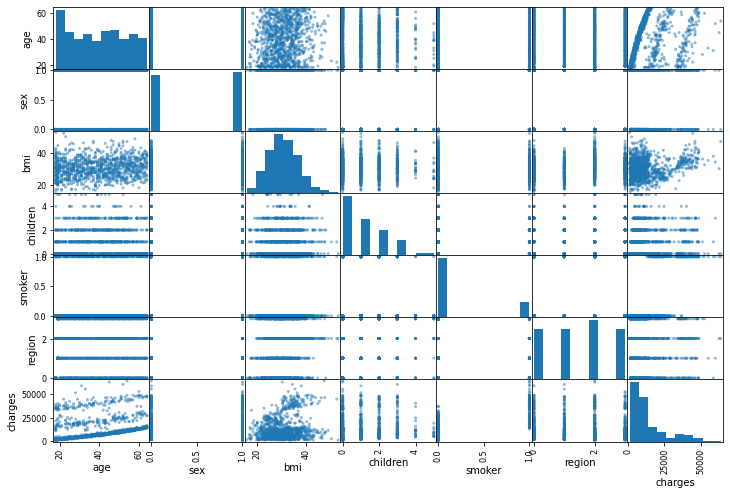

In [20]:
from pandas.plotting import scatter_matrix

attributes = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
scatter_matrix(strat_train_set[attributes], figsize=(12, 8))

# Attribute Engineering

Often, it is a good idea to try and combine attributes to further enrich the data of information that may not be there by the individual attributes. This is particularily used for numerical attributes. __Avoid using the label when combining features.__ This is important since the learning model may get information by the label indirectly through the combined attribute. Further, the label will not be available when we actually deploy the model (since we are trying to predict the label to begin with!)

The most promising attributes are `bmi` and `age`.

In [21]:
# Create dummy dataset so that we can play more safely with our dataset.
attr_eng_train_set = strat_train_set.copy()
attr_eng_train_set['bmi.per.year'] = attr_eng_train_set['bmi']/attr_eng_train_set['age']
attr_eng_train_set['bmi.year'] = attr_eng_train_set['bmi']*attr_eng_train_set['age']

In [22]:
corr_matrix = attr_eng_train_set.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges         1.000000
smoker          0.800094
bmi.year        0.314253
age             0.274163
bmi             0.209491
children        0.069946
sex             0.058434
region         -0.022080
bmi.per.year   -0.131442
Name: charges, dtype: float64

Note that `bmi.per.year` only has a slight negative correlation with charges. `bmi.year` on the other hand adds a better correlation than most other attributes. Because of this, we will add this new attribute combination to the original dataset so that when we resplit the dataset for learning, we keep this new attribute.

In [23]:
insurance['bmi.year'] = insurance['bmi']*insurance['age']

With our newly conceived knowledge about the dataset, we can resplit the dataset, now using a better estimate for splitting.

In [24]:
attrib = 'region'
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_i, test_i in split.split(insurance, insurance[attrib]):
    strat_train_set = insurance.loc[train_i]
    strat_test_set = insurance.loc[test_i]

strat_train_set.reset_index(inplace=True, drop=True)
strat_test_set.reset_index(inplace=True, drop=True)

# Dataset Preparation

Commonly, datasets have missing or invalid data. These data samples usually show as NaN values when looking at the data. In our case we do not have such an issue. This dataset has been precleaned by the dataset provided; thus, no further need for dataset cleaning is needed. In our other example with the Adult dataset we will encounter several missing values. Further discussion on how to work with incomplete data is given in the jupyter notebook for that dataset.

## Dealing with Categorical Data

Often, machine learning models need special representation of categorical attributes. The reason for this is on their training algorithms that use optimization strategies that require numerical values. Often, it is enough for us to replace categorical values with integers. The categorical values we will be dealing with are:`sex`, `smoker`, `region`.

In [25]:
strat_train_set.head()

,age,sex,bmi,children,smoker,region,charges,bmi.year
0,51,male,24.415,4,no,northwest,11520.09985,1245.165
1,28,female,25.935,1,no,northwest,4133.64165,726.180
2,18,female,31.350,0,no,southeast,1622.18850,564.300
3,50,male,25.300,0,no,southeast,8442.66700,1265.000
4,44,female,26.410,0,no,northwest,7419.47790,1162.040


### Encoding Categorical Attributes

There are seberal common ways to deal with categorical attributes. The first one is to encode categories using numbers for each respective category. In this manner, region northwest could be given a value of 0, northeast a value of 1, southwest a value of 2, and southeast a value of 3. This can be achieved by using eithwe `OrdinalEncoder` or `LabelEncoder` from scikit-learn.

Often, a third option is used called `OneHotEncoder`. One-hot encoding uses several columns to encode categorical data in bit-string format. for example, encoding the region attribute would use 4 columns. Each colum would represent whether a sample is of one type or another. For example, if the first column has a 1 and all other columns have a 0, then, we could say that the region is northwest. If the third column has a 1 and all other columns a value of 0, then we could say that the region for that sample is southwest. 

The benefit of using one-hot encoding is that by not placing a numerical value on the categories, we do not create a relationship among them where there may not exist one. For example, giving a higher value to southwest compare to northeast in region attribute could cause the machine learning algorithm to pick an inexisting relationship among attributes. One-hot encoding alleviates this problem.

In [26]:
from sklearn.preprocessing import OneHotEncoder
cat_attrs = ['sex', 'region', 'smoker']

ohe = OneHotEncoder()
ohe.fit(insurance[cat_attrs])
ohe_train = pd.DataFrame(ohe.transform(strat_train_set[cat_attrs]).toarray())
ohe_test = pd.DataFrame(ohe.transform(strat_test_set[cat_attrs]).toarray())

# Drop categorical data
strat_train_set.drop(cat_attrs, axis=1, inplace=True)
strat_test_set.drop(cat_attrs, axis=1, inplace=True)

# Replace with one-hot encoded data
strat_train_set = strat_train_set.join(ohe_train)
strat_test_set = strat_test_set.join(ohe_test)

# Kepp column names as string
strat_train_set.columns = strat_train_set.columns.astype(str)
strat_test_set.columns = strat_test_set.columns.astype(str)


In [27]:
strat_train_set.head()

,age,bmi,children,charges,bmi.year,0,1,2,3,4,5,6,7
0,51,24.415,4,11520.09985,1245.165,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,28,25.935,1,4133.64165,726.180,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,18,31.350,0,1622.18850,564.300,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,50,25.300,0,8442.66700,1265.000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,44,26.410,0,7419.47790,1162.040,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [28]:
strat_test_set.head()

,age,bmi,children,charges,bmi.year,0,1,2,3,4,5,6,7
0,40,41.420,1,28476.73499,1656.800,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,33,26.695,0,4571.41305,880.935,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,22,34.580,2,3925.75820,760.760,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,34,38.000,3,6196.44800,1292.000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,57,34.010,0,11356.66090,1938.570,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Feature Scalling

Sometimes, data comes in varying degrees of scales. For example, our dataset attribute `bmi.year` is widely distributed. This is evident when we look at the `describe()` function of the dataset and note the difference between max and min statistics. These large numbers can make machine learning models take longer than expected to learn a solution. to make learning easier, it is good practice to "standarize" or "noramlize" our data. There are two main ways by which this can be achieved:

- min-max scaling:
  - We use the difference between the minimum and maximum values in the dataset to keep data between 0 and 1.
- standarization:
  - We use the mean to "de-mean" the data. Then, we divide the data by the standard deviation to scale values to unit variances.

Note that the main difference is that min-max gives values between 0 and 1 and standarization does not.

There is no particular rule to when to use each type of scaling. It is a good idea to try both and compare how much each improves data prediction.

In [29]:
insurance.describe()

,age,bmi,children,charges,bmi.year
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,1211.575919
std,14.049960,6.098187,1.205493,12110.011237,522.608731
min,18.000000,15.960000,0.000000,1121.873900,287.280000
25%,27.000000,26.296250,0.000000,4740.287150,765.625000
50%,39.000000,30.400000,1.000000,9382.033000,1152.225000
75%,51.000000,34.693750,2.000000,16639.912515,1589.085000
max,64.000000,53.130000,5.000000,63770.428010,2845.480000


As a side note, it can be also a good idea to scale the charges attribute. This is common practice in machine learning, but it requires reversing this scaling to obtain the true estimate. Because we attempt to keep this workshop as simple as possible we will avoid this step for now. Further, this step is usually taken when the value is trully large such as in the quatrillions and above.

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


to_scale = ['bmi.year']
# We use two scalers to isolate both datasets
ss_train = StandardScaler()
ss_test = StandardScaler()
# mm_train = MinMaxScaler()
# mm_test = MinMaxScaler()

strat_train_set[to_scale] = ss_train.fit_transform(strat_train_set[to_scale])
strat_test_set[to_scale] = ss_test.fit_transform(strat_test_set[to_scale])

In [31]:
strat_train_set.describe()

,age,bmi,children,charges,bmi.year,0,1,2,3,4,5,6,7
count,1070.000000,1070.000000,1070.000000,1070.000000,1.070000e+03,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,38.988785,30.539458,1.100000,13138.892603,-2.556626e-16,0.479439,0.520561,0.242056,0.242991,0.271963,0.242991,0.802804,0.197196
std,14.134125,6.060059,1.213542,12045.116447,1.000468e+00,0.499811,0.499811,0.428528,0.429090,0.445179,0.429090,0.398068,0.398068
min,18.000000,15.960000,0.000000,1121.873900,-1.734773e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,26.125000,0.000000,4662.866675,-8.641093e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,39.000000,30.230000,1.000000,9257.146100,-1.055805e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,51.000000,34.422500,2.000000,16454.504562,7.085989e-01,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,3.113367e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Selection

There is a plethora of different machine learning models. Depending on the application, some models may be better than others. In this case, we are dealing with a classification problem. Because of this, some recomended models to try are:

- Ordinary Least Squares
- Ridge Regression
- Lasso
- Elastic Net
- Stochastic Gradient Descent
- Multi-Layer Perceptron

For training, we remove the labels from the training data. Leaving them in the dataset will be reminiscent to giving test answers to a class. It is common practice to use an X variable for the de-labeled data and y for the labels.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

model = RandomForestRegressor()

# Remove labels.
X = strat_train_set.drop(['charges'], axis=1)
# Put labels in different variable
y = strat_train_set['charges']

# Here it is where the magic happend
model.fit(X, y)

RandomForestRegressor()

In order for us to distinguish among models, it is a good idea to pick an accuracy estimator. There are many accuracy estimators that are used in different circumstances. Some of the most used are root mean squared error (RMSE) and mean absolute error (MAE). We highly recomend you read about other accuracy estimators for these estimators have special applications for different goals in data science.

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

train_pred = model.predict(X)

test_X = strat_test_set.drop(['charges'], axis=1)
test_pred = model.predict(test_X)
test_y = strat_test_set['charges']

train_rmse = np.sqrt(mean_squared_error(y, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))

train_mae = mean_absolute_error(y, train_pred)
test_mae = mean_absolute_error(test_y, test_pred)


In [34]:
print(f"Training Score: {train_rmse} | Testing Score: {test_rmse}")

Training Score: 1908.1250515237161 | Testing Score: 4431.645478863634


In [35]:
print(f"Training Score: {train_mae} | Testing Score: {test_mae}")

Training Score: 1039.22931815143 | Testing Score: 2439.7091857574687


As an interesting observation, testing a linear regressor produces a score that is worse for training dataset than testing dataset. This is because the the model may not be powerful enough for learning the relationships. Testing with a RandomForestRegressor produces a much better score.

In [36]:
test_pred[:20]

array([ 6592.88283  ,  7067.9799109,  7248.9161239,  6058.6503406,
       11621.6384418,  6696.016605 , 12132.3918058, 10343.5825846,
        3253.0449248, 11902.9916899, 19548.5872075,  4421.1573561,
       50164.0170948,  8322.4108547,  7943.7440335, 11975.6731628,
       17401.6393325, 11317.50149  , 23133.0832885,  7101.0472877])

In [37]:
test_y[:20]

0     28476.73499
1      4571.41305
2      3925.75820
3      6196.44800
4     11356.66090
5      6203.90175
6      9863.47180
7      9304.70190
8      1980.07000
9      8703.45600
10    12265.50690
11     3947.41310
12    48673.55880
13     8252.28430
14     7133.90250
15    10118.42400
16    18033.96790
17    10043.24900
18    21082.16000
19     6796.86325
Name: charges, dtype: float64

# Model Fine Tuning

As it can be appreciated, the scores obtained above are not phenomenal. The model definetely learns something, but the score reglects that when the model is put to the test, it still struggles. There can be many reasons for this, but one of the main reasons is that the model has not been fine tuned. Machine learning models come with pre-set attributes that may or may not be the best for a particular dataset. Because of this, it is a good idea to test different parameters. Often, testing new parameters will help the model perform better. Check out scikit-learn's documentation to find out about what parameters you can test to try.

In [38]:
from sklearn.model_selection import GridSearchCV

# Random Forest Regressor's
param_grid = [
    {
        'n_estimators': [50, 75, 100, 125, 150],
        'criterion': ['squared_error', 'absolute_error', 'poisson'],
    }
]
model = RandomForestRegressor()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=7)
grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=7,
             param_grid=[{'criterion': ['squared_error', 'absolute_error',
                                        'poisson'],
                          'n_estimators': [50, 75, 100, 125, 150]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [39]:
best_model = grid_search.best_estimator_

train_pred = best_model.predict(X)

test_X = strat_test_set.drop(['charges'], axis=1)
test_pred = best_model.predict(test_X)
test_y = strat_test_set['charges']

train_rmse = np.sqrt(mean_squared_error(y, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))

train_mae = mean_absolute_error(y, train_pred)
test_mae = mean_absolute_error(test_y, test_pred)


In [40]:
print(f"Training Score: {train_rmse} | Testing Score: {test_rmse}")

Training Score: 1874.7612068557428 | Testing Score: 4482.165253291535


In [41]:
print(f"Training Score: {train_mae} | Testing Score: {test_mae}")

Training Score: 1023.776666230096 | Testing Score: 2518.507381507813


Although slight, some improvement was made. Further fine tunning could make the score better.